In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.utils import resample

from pandas.tseries.holiday import USFederalHolidayCalendar

sns.set()

## 5.6 线性回归
如果说朴素贝叶斯是解决分类任务的好起点，那么线性回归模型就是解决回归任务的好起点。这些模型之所以大受欢迎，是因为它们的拟合速度非常快，而且很容易解释。

本节将先简单介绍线性回归背后的数学基础知识，然后介绍如何对线性回归模型进行一般化处理，使其能够解决数据中更复杂的模式。

### 5.6.1 简单线性回归
将数据拟合成一条直线是最广为人知的线性回归模型，直线拟合的模型方程为$y = ax + b$，其中$a$是直线斜率，$b$是直线截距。

下面的数据是从斜率为`2`、截距为`-5`的直线中抽取的散点(`图5-42`)：

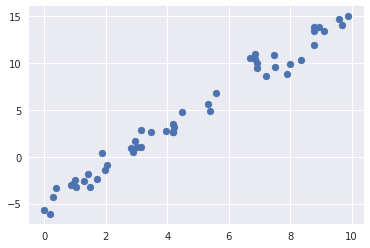

In [2]:
rng = np.random.RandomState(1) 
x = 10 * rng.rand(50) 
y = 2 * x - 5 + rng.randn(50) 
plt.scatter(x, y)
plt.show()

使用`Scikit-Learn`的`LinearRegression`评估器来拟合数据(`图5-43`)：

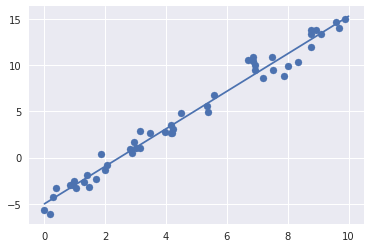

In [3]:
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000) 
yfit = model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.show()

数据的斜率和截距都在模型的拟合参数中，`Scikit-Learn`通常会在参数后面加一条下划线，即`coef_`和`intercept_`：

In [4]:
print("Model slope: ", model.coef_[0]) 
print("Model intercept:", model.intercept_)

Model slope:  2.02720881036
Model intercept: -4.99857708555


`LinearRegression`评估器不仅可以作简单的直线拟合，还可以处理多维度的线性回归模型：
+ $y = a_0 + a_1x_1 + a_2x_2 + …$ 

里面有多个$x$变量。从几何学的角度看，这个模型是拟合三维空间中的一个平面，或者是为更高维度的数据点拟合一个超平面。

这类回归模型的多维特性很难可视化，但是我们可以用`NumPy`的矩阵乘法运算符创建一些数据演示这类拟合过程：

In [5]:
rng = np.random.RandomState(1)

X = 10 * rng.rand(100, 3) 
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y) 
print("Model intercept:", model.intercept_) 
print("Model slope: ", model.coef_)

Model intercept: 0.5
Model slope:  [ 1.5 -2.   1. ]


其中$y$变量是由$3$个随机的$x$变量线性组合而成，线性回归模型还原了方程的系数。

`LinearRegression`评估器可以拟合数据的回归直线、平面和超平面了。这种方法还是有局限性的，因为它将变量限制在了线性关系上，但是不用担心，还有其他方法。

### 5.6.2 基函数回归
可以通过基函数对原始数据进行变换，从而将变量间的`线性回归模型`转换为`非线性回归模型`。 在`5.3`节和`5.4`节的`PolynomialRegression`管道示例中我们都有提及。这个方法的多维模型是：
+ $y = a_0 + a_1x_1 + a_2x_2 + …$ 

其中一维的输入变量$x$转换成了三维变量$x_1$、$x_2$和$x_3$。让$x_n = f_n(x)$，这里的$f_n()$是转换数据的函数。

假如$f_n(x) = x^n$，那么模型就会变成多项式回归：
+ $y = a_0 + a_1x + a_2x^2 + a_3x^3...$

**注意：这个模型仍然是线性模型，也就是说系数$a_n$彼此不会相乘或相除。我们其实是将一维的$x$投影到了高维空间，因此通过线性模型就可以拟合出$x$与$y$间更复杂的关系**。

#### 5.6.2.1 多项式基函数
多项式投影非常有用，`Scikit-Learn`的`PolynomialFeatures`转换器实现这个功能：

In [6]:
x = np.array([2, 3, 4]) 
poly = PolynomialFeatures(3, include_bias=False) 
poly.fit_transform(x[:, None])

array([[  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.]])

转换器通过指数函数，将一维数组转换成了三维数组。这个新的高维数组之后可以放在多项式回归模型中。

最简洁的方式是用管道实现这些过程，数据经过转换之后，可以用线性模型来拟合`x`和`y`之间更复杂的关系了。例如下面是带噪的正弦波(`图5-44`)：

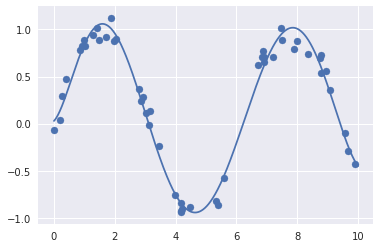

In [7]:
poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())

rng = np.random.RandomState(1)
x = 10 * rng.rand(50) 
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y) 
plt.plot(xfit, yfit)
plt.show()

通过运用7次多项式基函数，这个线性模型可以对非线性数据拟合出极好的效果！

#### 5.6.2.2 高斯基函数
还有其他类型的基函数。例如，高斯基函数也是常用的拟合模型方法，最终结果如`图5-45`所示：
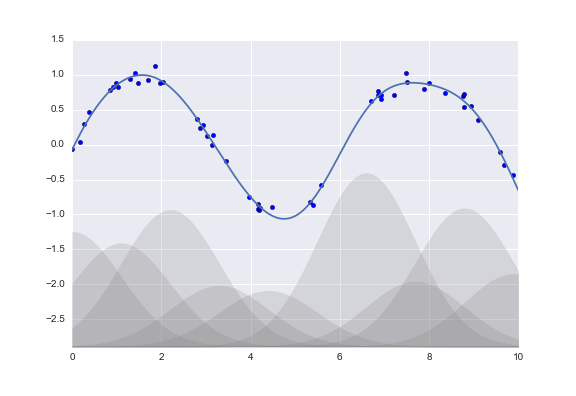

`图5-45`中的阴影部分代表不同规模基函数，把它们放在一起时就会产生平滑的曲线。`Scikit-Learn`并没有内置这些高斯基函数，但我们可以自己写一个转换器来创建高斯基函数，效果如`图5-46`所示(`Scikit-Learn`的转换器都是用Python类实现的，阅读`Scikit-Learn`的源代码可能更好地理解它们的创建方式)：

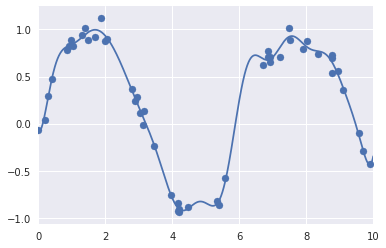

In [8]:
class GaussianFeatures(BaseEstimator, TransformerMixin):
    """一维输入均匀分布的高斯特征"""
    def __init__(self, N, width_factor=2.0): 
        self.N = N 
        self.width_factor = width_factor

    @staticmethod 
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width 
        return np.exp(-0.5 * np.sum(arg ** 2, axis))

    def fit(self, X, y=None):
        # 在数据区间中创建N个高斯分布中心 
        self.centers_ = np.linspace(X.min(), X.max(), self.N) 
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0]) 
        return self

    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

gauss_model = make_pipeline(GaussianFeatures(20), LinearRegression()) 
gauss_model.fit(x[:, np.newaxis], y) 
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y) 
plt.plot(xfit, yfit) 
plt.xlim(0, 10)
plt.show()

我们之所以将这个示例放在这里，是为了演示多项式基函数并不是什么魔法：如果你对数据的产生过程有某种直觉，那么就可以自己先定义一些基函数，然后像这样使用它们。

### 5.6.3 正则化
在线性回归模型中引入基函数会让模型变得更加灵活，但是也很容易造成过拟合。例如，如果选择了太多高斯基函数，那么最终的拟合结果看起来可能并不好(`图5-47`所示)：

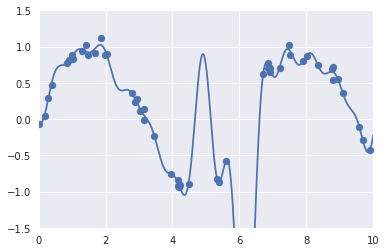

In [9]:
model = make_pipeline(GaussianFeatures(30), LinearRegression()) 

model.fit(x[:, np.newaxis], y)
plt.scatter(x, y) 
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))
plt.xlim(0, 10) 
plt.ylim(-1.5, 1.5)
plt.show()

如果将数据投影到30维的基函数上，模型变得过于灵活，从而能够适应数据中的异常值。如果将高斯基函数的系数画出来，就可以看到过拟合的原因(`图5-48`)：

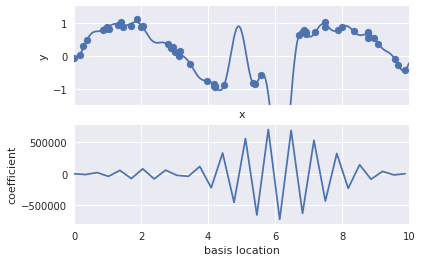

In [10]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True) 
    model.fit(x[:, np.newaxis], y) 
    ax[0].scatter(x, y) 
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis])) 
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))

    if title:
        ax[0].set_title(title)
    
    ax[1].plot(model.steps[0][1].centers_, model.steps[1][1].coef_) 
    ax[1].set(xlabel='basis location', ylabel='coefficient', xlim=(0, 10))

model = make_pipeline(GaussianFeatures(30), LinearRegression()) 
basis_plot(model)
plt.show()

`图5-48`下面那幅图显示了每个位置上基函数的振幅。当基函数重叠的时候，通常就表明出 现了过拟合：相邻基函数的系数相互抵消。这显然是有问题的，如果对较大的模型参数进 行惩罚（penalize），从而抑制模型剧烈波动，应该就可以解决这个问题了。这个惩罚机制 被称为正则化（regularization），有几种不同的表现形式。

#### 5.6.3.1 岭回归($L_2$范数正则化)
正则化最常见的形式是`岭回归`(`ridge regression`，或者`$L_2$范数正则化`)，也被称为`Tikhonov regularization`。其处理方法是对模型系数平方和($L_2$范数)进行惩罚，模型拟合的惩罚项为：
+ $P = \alpha\sum_{n=1}^{N}\theta_{n}^{2}$

其中，$\alpha$是一个自由参数，用来控制惩罚的力度。这种带惩罚项的模型内置在`Scikit-Learn`的`Ridge`评估器中(`图5-49`)：

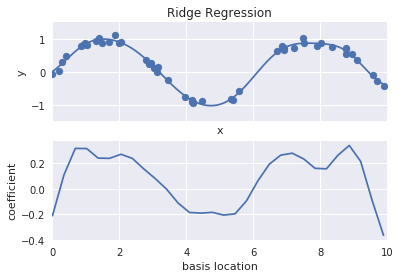

In [11]:
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1)) 
basis_plot(model, title='Ridge Regression')
plt.show()

参数$\alpha$是控制最终模型复杂度的关键。如果$\alpha \to 0$，那么模型就恢复到标准线性回归结果；如果$\alpha \to \infty$，那么所有模型响应都会被压制。岭回归的一个重要优点是，它可以非常高效地计算，相比原始的线性回归模型，几乎没有消耗更多的计算资源。

#### 5.6.3.2 Lasso正则化($L_1$范数)
另一种常用的正则化被称为`Lasso`，其处理方法是对模型系数绝对值的和($L_1$范数)进行惩罚：
+ $P = \alpha\sum_{n=1}^{N}\lvert\theta_n\rvert$

`Lasso`正则化结果与岭回归差别很大。由于其几何特性，`Lasso`正则化倾向于构建稀疏模型，即它更喜欢将模型系数设置为0。

用模型系数的$L_1$范数正则化实现的(`图5-50`)：

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


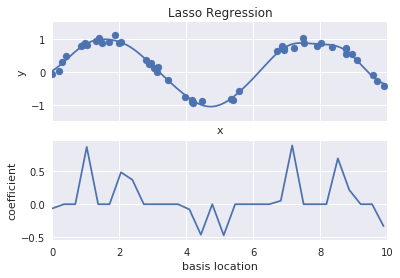

In [12]:
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001)) 
basis_plot(model, title='Lasso Regression')
plt.show()

通过`Lasso`回归惩罚，大多数基函数的系数都变成了0，所以模型变成了原来基函数的一小部分。参数$\alpha$控制惩罚力度，可以通过交叉检验来确定。

## 5.6.4 案例：预测自行车流量
下面来尝试预测美国西雅图弗雷蒙特桥的自行车流量，数据源自不同天气、季节和其他条件下通过该桥的自行车统计数据。我们将自行车数据与其他数据集连接起来，确定哪些天气和季节因素会影响通过这座桥的自行车流量。 NOAA已经提供了[每日的站点天气预报](http://www.ncdc.noaa.gov/cdo-web/search? datasetid=GHCND)数据(我们用的站点ID是`USW00024233`)，可以用Pandas将两份数据连接起来。然后，创建一个线性回归模型来探索与自行车数量相关的天气和其他因素，从而评估任意一种因素对骑车人数的影响。

值得注意的是，这是一个演示在统计模型框架中如何应用`Scikit-Learn`工具的案例，模型参数被假设为具有可以解释的含义。就像前面介绍过的那样，虽然这并不是一个介绍标准 机器学习方法的案例，但是对模型的解释在其他模型中也会用到。

首先加载两个数据集，用日期作索引：

In [13]:
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True) 
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)
counts.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2012-10-03 00:00:00,9.0,4.0
2012-10-03 01:00:00,6.0,4.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,3.0,2.0
2012-10-03 04:00:00,1.0,6.0


In [14]:
# 需要把日期对齐，否则可能出现NaN的特征值
weather = weather.truncate(before='2012-10-03')
counts = counts.truncate(after='2015-09-01')

计算每一天的自行车流量：

In [15]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
# remove other columns
daily = daily[['Total']] 
daily.head()

,Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0


我们发现同一周内每一天的模式都是不一样的。因此在数据中加上7列`0~1`值表示`星期几`：

In [16]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


我们觉得骑车人数在节假日也有所变化。因此，再增加一列表示当天是否为节假日：

In [17]:
cal = USFederalHolidayCalendar() 
holidays = cal.holidays('2012', '2018') 
daily = daily.join(pd.Series(1, index=holidays, name='holiday')) 
daily['holiday'].fillna(0, inplace=True)

我们还认为白昼时间也会影响骑车人数。因此，用标准的天文计算来添加这列信息(`图5-51`)：

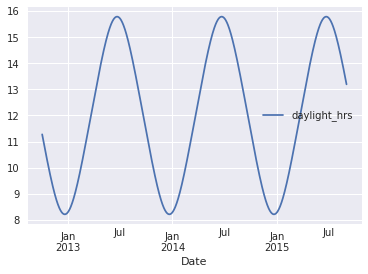

In [18]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """计算指定日期的白昼时间""" 
    days = (date - pd.datetime(2000, 12, 21)).days 
    m = (1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days*2*np.pi/365.25))) 
    return 24. * np.degrees(np.arccos(1-np.clip(m,0,2)))/180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index)) 
daily[['daylight_hrs']].plot()
plt.show()

我们还可以增加每一天的平均气温和总降雨量。除了降雨量的数值之外，再增加一个标记表示是否下雨(是否降雨量为0)：

In [19]:
# 温度是按照1/10摄氏度统计的，首先转换为摄氏度
weather['TMIN'] /= 10 
weather['TMAX'] /= 10 
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# 降雨量也是按照1/10mm统计的，转化为英寸 
weather['PRCP'] /= 254 
weather['dry day'] = (weather['PRCP'] == 0).astype(int)
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1


最后增加一个计数器，表示一年已经过去了多少天。这个特征可以让我们看到每一年自行车流量的增长或减少：

In [20]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1,0.010959


有了这些数据之后，就可以选择需要使用的列，然后对数据建立线性回归模型。我们不在模型中使用截距，设置`fit_intercept = False`，因为每一天的总流量(`Total`字段)基本上可以作为当天的截距(*其实此线性回归模型使用截距拟合结果也不变*)：

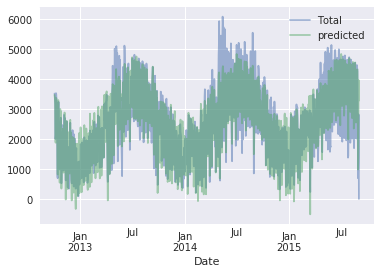

In [21]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun',
               'holiday', 'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual'] 
X = daily[column_names] 
y = daily['Total']

model = LinearRegression(fit_intercept=False) 
model.fit(X, y) 
daily['predicted'] = model.predict(X)

daily[['Total', 'predicted']].plot(alpha=0.5)
plt.show()

显然，我们丢失了一些关键特征，尤其是夏天的预测数据。要么是由于特征没有收集全，要么是有一些非线性关系我们没有考虑到(例如，可能人们在温度过高或过低时都不愿意骑车)。但是，这个近似解已经足以说明问题。下面让我们看看模型的系数，评估各个特征对每日自行车流量的影响：

In [22]:
params = pd.Series(model.coef_, index=X.columns) 
params

Mon              511.786646
Tue              598.435503
Wed              599.430757
Thu              489.403923
Fri              185.239919
Sat            -1096.815902
Sun            -1126.932722
holiday        -1188.601566
daylight_hrs     128.713236
PRCP            -662.607271
dry day          557.321956
Temp (C)          64.961803
annual            21.074255
dtype: float64

如果不对这些数据的不确定性进行评估，那么它们很难具有解释力。可以用自举重采样方法快速计算数据的不确定性：

In [23]:
np.random.seed(1) 
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

有了估计误差之后，再来看这些结果：

In [24]:
print(pd.DataFrame({'effect': params.round(0), 'error': err.round(0)}))

              effect  error
Mon            512.0   87.0
Tue            598.0   84.0
Wed            599.0   84.0
Thu            489.0   86.0
Fri            185.0   82.0
Sat          -1097.0   80.0
Sun          -1127.0   84.0
holiday      -1189.0  163.0
daylight_hrs   129.0    9.0
PRCP          -663.0   62.0
dry day        557.0   35.0
Temp (C)        65.0    4.0
annual          21.0   19.0


首先，星期特征是比较稳定的，工作日骑车的人数显然比周末和节假日要多。其次，白昼时间每增加1小时，就平均增加`129±9`个骑车的人；而温度每上升1度，则增加`65±4`个骑车的人；如果那天没下雨，那么骑车人数增加`546±33`人；降雨量每增加1英寸，骑车人数减少`665±62`人。当所有影响因素都生效之后，一年中每多一天骑车人数增加(日环比增幅)`28±18`人。

我们的模型的确丢失了一些重要信息。例如，变量的非线性影响因素(例如降雨和寒冷天气的影响)和非线性趋势(例如人们在温度过高或过低时可能都不愿意骑车)在模型中都没有体现。另外，我们丢掉了一些细颗粒度的数据(例如下雨天的早晨和下雨天的傍晚之间的差异)，还忽略了相邻日期彼此间的相关性(例如下雨的星期二对星期三骑车人数的影响，或者滂沱大雨之后意外的雨过天晴对骑车人数的影响)，这些都可能对骑车人数产生影响。现在你手上已经有了工具，如果愿意，可以进一步进行分析。
